<a href="https://colab.research.google.com/github/yazeedMohi/Scene-Text-Localization/blob/master/STL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Scene Text Localization**

## Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Run Here

**Main(**source,arch,best,lr,transform,image,train,epochs,batch_size**)**

**source**: dataset/model name (*totaltext*, *icpr*, *icpr2*, *svt*).

**arch**: network to be used (*east*).

**transform**: transform dataset to the HDF5 file (hdf5 files are better for processing and training).

**cv2**: visualize sample from transformed dataset.

**image**: predict a single image with the source parameter, Special inputs: "**sample**" -> random sample from dataset, "**sampleOut**" -> random sample from dataset with its groundtruth as output.

**train**: train model with the source argument.

**epochs**: number of epochs.

**batch_size**: number of examples per batch.

-1 -1


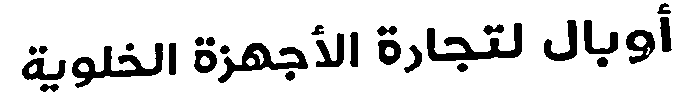

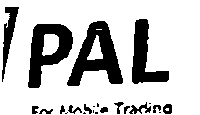

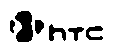

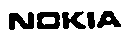

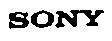

0.0
[1.89760071 1.89760071 0.         0.        ]
quad invalid with vertex num less then 4.
0.0
[0. 0. 0. 0.]
quad invalid with vertex num less then 4.
0.0
[0. 0. 0. 0.]
quad invalid with vertex num less then 4.
0.0
[0. 0. 0. 0.]
quad invalid with vertex num less then 4.
0.0
[0. 0. 0. 0.]
quad invalid with vertex num less then 4.
0.0
[0.         0.         1.90093303 1.90093303]
quad invalid with vertex num less then 4.


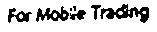

0.0
[0. 0. 0. 0.]
quad invalid with vertex num less then 4.
0.0
[0.         0.         0.96237677 0.96237677]
quad invalid with vertex num less then 4.


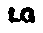

0.0
[0. 0. 0. 0.]
quad invalid with vertex num less then 4.
0.0
[0. 0. 0. 0.]
quad invalid with vertex num less then 4.
0.0
[0.         0.         1.88860822 1.88860822]
quad invalid with vertex num less then 4.


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


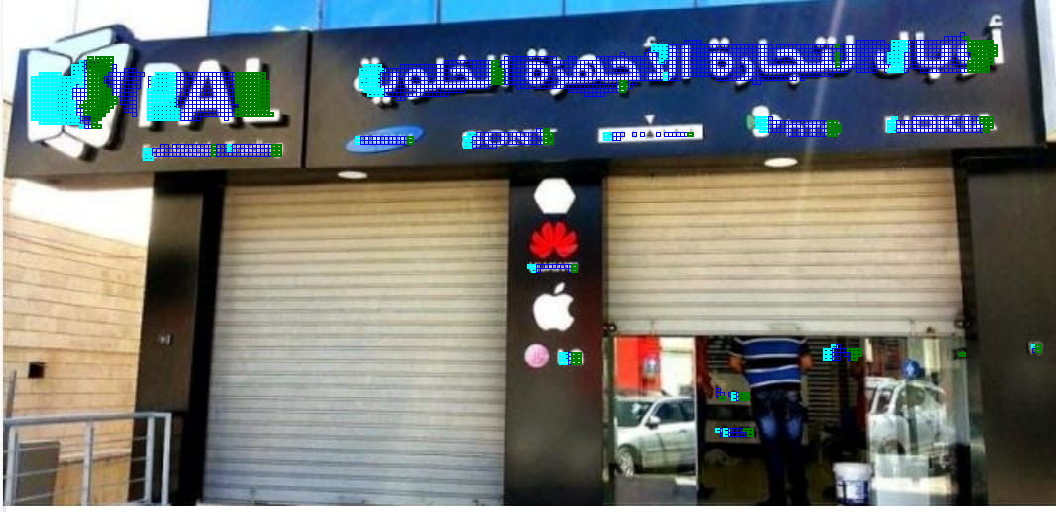

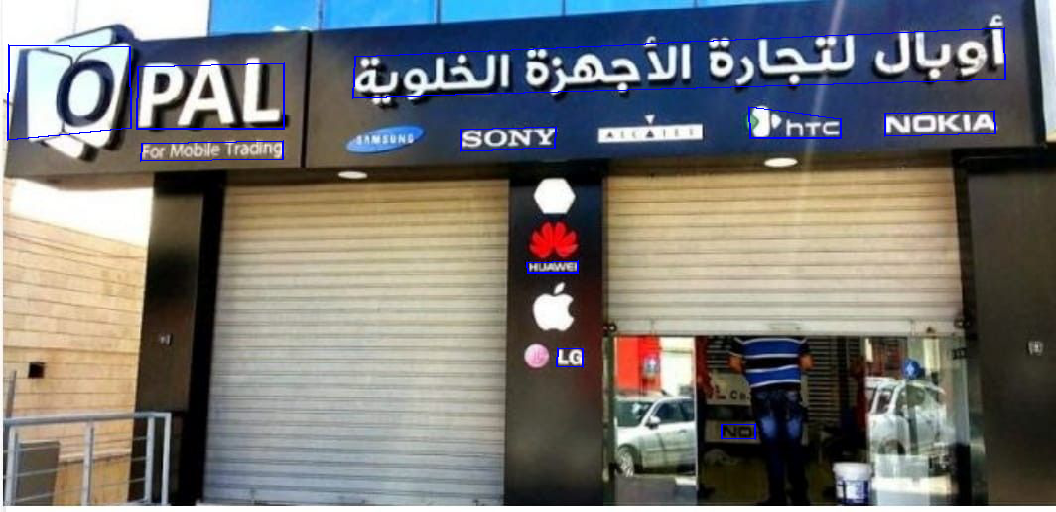

['354.06641642920886,57.93947724642534,352.2467630683934,97.80614607710268,1005.8867593210045,78.68341597920103,1004.7680407134387,28.377413562022806\n', '8.087100608487434,45.586044457703636,7.8481570035242365,139.67826664327734,131.23348974464434,127.39655006726362,130.9767429350683,47.18559696177029\n', '137.56017590080594,67.66986524235134,136.24780613990077,128.4304683562018,284.97632246843824,128.230956903028,284.3973759583899,63.385817382230506\n', '748.9954639626083,107.74795604364203,749.2620740424104,137.07410402306257,841.60583516755,137.80338026957952,841.6143839682592,119.02469476340076\n', '884.7185854761792,114.45422790125102,884.2645816424755,135.60496827862372,995.6047415276616,132.99331341760538,994.877322481814,111.62108169265456\n', '460.78092857496273,130.65608736527267,460.9453217660712,150.55090567946536,555.9711182624166,147.07414451507927,556.1730921006224,127.18177083521525\n', '141.13252005729666,144.78348762705576,140.4598391329817,160.2597164469141,283.5928

In [164]:
Main(source="icpr", image="/content/drive/My Drive/data/demo/sign1.jpg")

## Config

In [163]:
%tensorflow_version 2.1
import os
class CFG:
    def __init__(self):
        self.initial_epoch = 0
        self.validation_split_ratio = 0.1
        self.max_train_img_size = int(384)
        self.max_predict_img_size = int(1536)
        assert self.max_train_img_size in [256, 384, 512, 640, 736], \
            'max_train_img_size must in [256, 384, 512, 640, 736]'
        if self.max_train_img_size == 256:
            self.batch_size = 8
        elif self.max_train_img_size == 384:
            self.batch_size = 4
        elif self.max_train_img_size == 512:
            self.batch_size = 2
        else:
            self.batch_size = 1
        
        self.origin_image_dir_name = 'Images/Train/'
        self.origin_txt_dir_name = 'GroundTruths/Train/'
        self.origin_image_dir_name_test = 'Images/Test/'
        self.origin_txt_dir_name_test = 'GroundTruths/Test/'
        
        # in paper it's 0.3, maybe to large to this problem
        self.shrink_ratio = 0.2
        self.expand_ratio = -0.375
        # pixels between 0.2 and 0.6 are side pixels
        self.shrink_side_ratio = 0.6
        self.epsilon = 1e-4

        self.num_channels = 3
        self.feature_layers_range = range(5, 1, -1)
        self.feature_layers_num = len(self.feature_layers_range)
        self.pixel_size = 2 ** self.feature_layers_range[-1]
        self.locked_layers = False

        
        
        self.pixel_threshold = 0.9
        self.side_vertex_pixel_threshold = 0.9
        self.trunc_threshold = 0.1
        self.predict_cut_text_line = True
        self.predict_write_txt = False
        self.show_process = False
        
        # Post-Processing
        self.segment_region_threshold = 10
cfg = CFG()

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


## Main

In [0]:
"""
Provides general interface to the project.
"""

import argparse
import cv2
import h5py
import os
import string
import datetime

def Main(source,arch="east",best=False,lr=5e-4,transform=False,image="",train=False,test=False,epochs=1000,batch_size=8):

    # Change those as needed
    raw_path = "/content/drive/My Drive/raw"
    source_path = os.path.join("/content/drive/My Drive/", "data", str(source)+".hdf5")
    output_path = os.path.join("/content/drive/My Drive/", "output", source, arch)
    file_name = "checkpoint_weights.hdf5"
    if best:
        file_name = "best_weights.hdf5"
    target_path = os.path.join(output_path, file_name)
    
    
    if transform:
        # Transforming dataset to HDF5 format
        
        assert os.path.exists(raw_path) # Otherwise raise exception
        
        print("The "+str(source)+" dataset will be transformed...")

        ds = Dataset(source=raw_path, name=source)
        ds.read_partitions()
        
        print("Partitions will be preprocessed...")
        ds.preprocess_partitions()

        print("Partitions will be saved...")
        os.makedirs(os.path.dirname(source_path), exist_ok=True)
        for i in ds.partitions:
            with h5py.File(source_path, "a") as hf:
                hf.create_dataset(str(i)+"/dt", data=ds.dataset[i]['dt'], compression="gzip", compression_opts=9)
                hf.create_dataset(str(i)+"/gt", data=ds.dataset[i]['gt'], compression="gzip", compression_opts=9)
                print("[OK] "+str(i)+" partition.")
        print("Transformation finished.")

    elif image:
        
        model = NNModel(architecture=arch)

        model.compile()
        model.load_checkpoint(target=target_path)
        dtgen = DataGenerator(source=source_path,
                              batch_size=batch_size)
        predict_image(model.model,image,cfg.pixel_threshold,gen=dtgen)

    else:
        # Either training or testing
        assert os.path.isfile(source_path) or os.path.isfile(target_path)
        os.makedirs(output_path, exist_ok=True)

        dtgen = DataGenerator(source=source_path,
                              batch_size=batch_size)
        # Creating a model
        model = NNModel(architecture=arch)

        # set `learning_rate` parameter or get architecture default value
        model.compile(learning_rate=lr)
        model.load_checkpoint(target=target_path)
        
        if train:
            print("Train images: "+str(dtgen.size['train']))
            print("Validation images: "+str(dtgen.size['valid']))
            #print("Test images: "+str(dtgen.size['test']))
            model.summary(output_path, "summary.txt")

            callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

            start_time = datetime.datetime.now()
            h = model.fit(x=dtgen.next_train_batch(),
                          epochs=epochs,
                          steps_per_epoch=dtgen.steps['train'],
                          validation_data=dtgen.next_valid_batch(),
                          validation_steps=dtgen.steps['valid'],
                          callbacks=callbacks,
                          shuffle=True,
                          verbose=1)

            total_time = datetime.datetime.now() - start_time

            loss = h.history['loss']
            val_loss = h.history['val_loss']

            min_val_loss = min(val_loss)
            min_val_loss_i = val_loss.index(min_val_loss)

            time_epoch = (total_time / len(loss))
            total_item = (dtgen.size['train'] + dtgen.size['valid'])
            t_corpus = ""
            t_corpus = "\n".join([
                f"Total train images:      {dtgen.size['train']}",
                f"Total validation images: {dtgen.size['valid']}",
                f"Batch:                   {dtgen.batch_size}\n",
                f"Total time:              {total_time}",
                f"Time per epoch:          {time_epoch}",
                f"Time per item:           {time_epoch / total_item}\n",
                f"Total epochs:            {len(loss)}",
                f"Best epoch               {min_val_loss_i + 1}\n",
                f"Training loss:           {loss[min_val_loss_i]:.8f}",
                f"Validation loss:         {min_val_loss:.8f}"
            ])

            with open(os.path.join(output_path, "train.txt"), "w") as lg:
                lg.write(t_corpus)
                print(t_corpus)

        elif test:
            print("Test images: "+str(dtgen.size['test']))
            """start_time = datetime.datetime.now()

            predicts, _ = model.predict(x=dtgen.next_test_batch(),
                                        steps=dtgen.steps['test'],
                                        ctc_decode=True,
                                        verbose=1)

            predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]

            total_time = datetime.datetime.now() - start_time

            with open(os.path.join(output_path, "predict.txt"), "w") as lg:
                for pd, gt in zip(predicts, dtgen.dataset['test']['gt']):
                    lg.write("TE_L "+str(gt)+"\nTE_P" +str(pd)+"\n")

            evaluate = ocr_metrics(predicts=predicts,
                                              ground_truth=dtgen.dataset['test']['gt'],
                                              norm_accentuation=False,
                                              norm_punctuation=False)

            e_corpus = ""
            e_corpus = "\n".join([
                f"Total test images:    {dtgen.size['test']}",
                f"Total time:           {total_time}",
                f"Time per item:        {total_time / dtgen.size['test']}\n",
                f"Metrics:",
                f"Character Error Rate: {evaluate[0]:.8f}",
                f"Word Error Rate:      {evaluate[1]:.8f}",
                f"Sequence Error Rate:  {evaluate[2]:.8f}"
            ])

            with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
                lg.write(e_corpus)
                print(e_corpus)"""

## Models

In [0]:

"""
NNModel Class
The NNModel class use Tensorflow Keras module.

x is the input features and y the labels.
"""
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf


##SET DEFS
class NNModel:

    def __init__(self,
                 architecture="east",
                 num_channels=3,
                 locked_layers=False,
                 feature_layers_range=range(5, 1, -1),
                 feature_layers_num=4,
                 learning_rate=1e-3
                ):
        """
        Initialization of a NN Model.

        parameters:
            architecture: option of the architecture model to build and compile.
        """

        self.architecture = globals()[architecture]
        self.num_channels = num_channels
        self.locked_layers = locked_layers
        self.feature_layers_range = feature_layers_range
        self.feature_layers_num = feature_layers_num
        self.learning_rate = learning_rate
        
        self.model= None

    def summary(self, output=None, target=None):
        """Show/Save model structure (summary)"""

        self.model.summary()

        if target is not None:
            os.makedirs(output, exist_ok=True)

            """with open(os.path.join(output, target), "w") as f:
                with redirect_stdout(f):
                    self.model.summary()"""

    def load_checkpoint(self, target):
        """ Load a model with checkpoint file"""

        if os.path.isfile(target):
            if self.model is None:
                self.compile()

            self.model.load_weights(target)

    def get_callbacks(self, logdir, checkpoint, monitor="val_loss", verbose=0):
        """Setup the list of callbacks for the model"""

        callbacks = [
            CSVLogger(
                filename=os.path.join(logdir, "epochs.log"),
                separator=";",
                append=True),
            TensorBoard(
                log_dir=logdir,
                write_graph=True,
                write_images=False,
                update_freq="epoch"),
            ModelCheckpoint(
                filepath=checkpoint,
                monitor=monitor,
                save_best_only=True,
                save_weights_only=True,
                verbose=verbose),
            EarlyStopping(
                monitor=monitor,
                min_delta=1e-8,
                patience=20,
                restore_best_weights=True,
                verbose=verbose),
            ReduceLROnPlateau(
                monitor=monitor,
                min_delta=1e-8,
                factor=0.2,
                patience=15,
                verbose=verbose)
        ]

        """callbacks = [
            EarlyStopping(patience=5, verbose=1),
            ModelCheckpoint(filepath=checkpoint,
                            save_best_only=True,
                            save_weights_only=True,
                            verbose=1)]"""


        return callbacks
    def compile(self, learning_rate=None):
        """
        Configures the NN Model for training/predict.

        optimizer: optimizer for training
        """

        # define inputs, outputs and optimizer of the chosen architecture
        outs = self.architecture(self.num_channels, self.locked_layers, self.feature_layers_range, self.feature_layers_num, self.learning_rate)
        inputs, outputs, optimizer = outs

        # create and compile
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=optimizer, loss=self.quad_loss)

    def fit(self,
            x=None,
            y=None,
            batch_size=None,
            epochs=1,
            verbose=1,
            callbacks=None,
            validation_split=0.0,
            validation_data=None,
            shuffle=True,
            class_weight=None,
            sample_weight=None,
            initial_epoch=0,
            steps_per_epoch=None,
            validation_steps=None,
            validation_freq=1,
            max_queue_size=10,
            workers=1,
            use_multiprocessing=False,
            checkpoint=""):
        """
        Model training on data yielded (fit_generator function has support to generator).
        A fit_generator() abstration function of TensorFlow Keras.

        Provide x parameter, a generator of the form: yielding x, y.

        return: A history object
        """

        out = self.model.fit_generator(generator=x,
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           validation_data=validation_data,
                           validation_steps=validation_steps,
                           verbose=1,
                           initial_epoch=initial_epoch,
                           callbacks=callbacks)
        return out

    def predict(self,
                x,
                batch_size=None,
                verbose=0,
                steps=1,
                callbacks=None,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False):
        pass

    @staticmethod
    def quad_loss(y_true, y_pred):
        
        epsilon = 1e-6
        lambda_side_vertex_coord_loss = 1.0
        lambda_side_vertex_code_loss = 1.0
        lambda_inside_score_loss = 4.0
        def smooth_l1_loss(prediction_tensor, target_tensor, weights):
            n_q = tf.reshape(quad_norm(target_tensor), tf.shape(weights))
            diff = prediction_tensor - target_tensor
            abs_diff = tf.abs(diff)
            abs_diff_lt_1 = tf.less(abs_diff, 1)
            pixel_wise_smooth_l1norm = (tf.reduce_sum(
                tf.where(abs_diff_lt_1, 0.5 * tf.square(abs_diff), abs_diff - 0.5),
                axis=-1) / n_q) * weights
            return pixel_wise_smooth_l1norm


        def quad_norm(g_true):
            shape = tf.shape(g_true)
            delta_xy_matrix = tf.reshape(g_true, [-1, 2, 2])
            diff = delta_xy_matrix[:, 0:1, :] - delta_xy_matrix[:, 1:2, :]
            square = tf.square(diff)
            distance = tf.sqrt(tf.reduce_sum(square, axis=-1))
            distance *= 4.0
            distance += epsilon
            return tf.reshape(distance, shape[:-1])
        
        
        # loss for inside_score
        logits = y_pred[:, :, :, :1]
        labels = y_true[:, :, :, :1]
        # balance positive and negative samples in an image
        beta = 1 - tf.reduce_mean(labels)
        # first apply sigmoid activation
        predicts = tf.nn.sigmoid(logits)
        # log +epsilon for stable cal
        inside_score_loss = tf.reduce_mean(
            -1 * (beta * labels * tf.math.log(predicts + epsilon) +
                  (1 - beta) * (1 - labels) * tf.math.log(1 - predicts + epsilon)))
        inside_score_loss *= lambda_inside_score_loss

        # loss for side_vertex_code
        vertex_logits = y_pred[:, :, :, 1:3]
        vertex_labels = y_true[:, :, :, 1:3]
        vertex_beta = 1 - (tf.reduce_mean(y_true[:, :, :, 1:2])
                           / (tf.reduce_mean(labels) + epsilon))
        vertex_predicts = tf.nn.sigmoid(vertex_logits)
        pos = -1 * vertex_beta * vertex_labels * tf.math.log(vertex_predicts +
                                                        epsilon)
        neg = -1 * (1 - vertex_beta) * (1 - vertex_labels) * tf.math.log(
            1 - vertex_predicts + epsilon)
        positive_weights = tf.cast(tf.equal(y_true[:, :, :, 0], 1), tf.float32)
        side_vertex_code_loss = \
            tf.reduce_sum(tf.reduce_sum(pos + neg, axis=-1) * positive_weights) / (
                    tf.reduce_sum(positive_weights) + epsilon)
        side_vertex_code_loss *= lambda_side_vertex_code_loss

        # loss for side_vertex_coord delta
        g_hat = y_pred[:, :, :, 3:]
        g_true = y_true[:, :, :, 3:]
        vertex_weights = tf.cast(tf.equal(y_true[:, :, :, 1], 1), tf.float32)
        pixel_wise_smooth_l1norm = smooth_l1_loss(g_hat, g_true, vertex_weights)
        side_vertex_coord_loss = tf.reduce_sum(pixel_wise_smooth_l1norm) / (
                tf.reduce_sum(vertex_weights) + epsilon)
        side_vertex_coord_loss *= lambda_side_vertex_coord_loss
        
        return inside_score_loss + side_vertex_code_loss + side_vertex_coord_loss



"""
Networks to the text localization
"""

def east(num_channels, locked_layers, feature_layers_range, feature_layers_num, learning_rate):
    input_img = Input(name='input_img',
                               shape=(None, None, num_channels),
                               dtype='float32')
    vgg16 = VGG16(input_tensor=input_img,
                  weights='imagenet',
                  include_top=False)
    if locked_layers:
        # locked first two conv layers
        locked_layers = [vgg16.get_layer('block1_conv1'),
                         vgg16.get_layer('block1_conv2')]
        for layer in locked_layers:
            layer.trainable = False
    f = [vgg16.get_layer('block%d_pool' % i).output
              for i in feature_layers_range]
    f.insert(0, None)
    diff = feature_layers_range[0] - feature_layers_num
    
    def g(i):
        # i+diff in cfg.feature_layers_range
        assert i + diff in feature_layers_range, \
            ('i=%d+diff=%d not in ' % (i, diff)) + \
            str(feature_layers_range)
        if i == feature_layers_num:
            bn = BatchNormalization()(h(i))
            cn = Conv2D(32, 3, activation='relu', padding='same')(bn)
            return cn
        else:
            return UpSampling2D((2, 2))(h(i))

    def h(i):
        # i+diff in cfg.feature_layers_range
        assert i + diff in feature_layers_range, \
            ('i=%d+diff=%d not in ' % (i, diff)) + \
            str(feature_layers_range)
        if i == 1:
            return f[i]
        else:
            concat = Concatenate(axis=-1)([g(i - 1), f[i]])
            bn1 = BatchNormalization()(concat)
            conv_1 = Conv2D(128 // 2 ** (i - 2), 1,
                            activation='relu', padding='same',)(bn1)
            bn2 = BatchNormalization()(conv_1)
            conv_3 = Conv2D(128 // 2 ** (i - 2), 3,
                            activation='relu', padding='same',)(bn2)
            return conv_3

    before_output = g(feature_layers_num)
    inside_score = Conv2D(1, 1, padding='same', name='inside_score'
                          )(before_output)
    side_v_code = Conv2D(2, 1, padding='same', name='side_vertex_code'
                         )(before_output)
    side_v_coord = Conv2D(4, 1, padding='same', name='side_vertex_coord'
                          )(before_output)
    east_detect = Concatenate(axis=-1,
                              name='east_detect')([inside_score,
                                                   side_v_code,
                                                   side_v_coord])
    
    optimizer = Adam(lr=learning_rate, decay=5e-4)
    
    return (input_img, east_detect, optimizer)

## Preprocessing

In [0]:
def batch_reorder_vertexes(xy_list_array):
    reorder_xy_list_array = np.zeros_like(xy_list_array)
    for xy_list, i in zip(xy_list_array, range(len(xy_list_array))):
        reorder_xy_list_array[i] = reorder_vertexes(xy_list)
    return reorder_xy_list_array


def reorder_vertexes(xy_list):
    reorder_xy_list = np.zeros_like(xy_list)
    # determine the first point with the smallest x,
    # if two has same x, choose that with smallest y,
    ordered = np.argsort(xy_list, axis=0)
    xmin1_index = ordered[0, 0]
    xmin2_index = ordered[1, 0]
    if xy_list[xmin1_index, 0] == xy_list[xmin2_index, 0]:
        if xy_list[xmin1_index, 1] <= xy_list[xmin2_index, 1]:
            reorder_xy_list[0] = xy_list[xmin1_index]
            first_v = xmin1_index
        else:
            reorder_xy_list[0] = xy_list[xmin2_index]
            first_v = xmin2_index
    else:
        reorder_xy_list[0] = xy_list[xmin1_index]
        first_v = xmin1_index
    # connect the first point to others, the third point on the other side of
    # the line with the middle slope
    others = list(range(4))
    others.remove(first_v)
    k = np.zeros((len(others),))
    for index, i in zip(others, range(len(others))):
        k[i] = (xy_list[index, 1] - xy_list[first_v, 1]) \
                    / (xy_list[index, 0] - xy_list[first_v, 0] + cfg.epsilon)
    k_mid = np.argsort(k)[1]
    third_v = others[k_mid]
    reorder_xy_list[2] = xy_list[third_v]
    # determine the second point which on the bigger side of the middle line
    others.remove(third_v)
    b_mid = xy_list[first_v, 1] - k[k_mid] * xy_list[first_v, 0]
    second_v, fourth_v = 0, 0
    for index, i in zip(others, range(len(others))):
        # delta = y - (k * x + b)
        delta_y = xy_list[index, 1] - (k[k_mid] * xy_list[index, 0] + b_mid)
        if delta_y > 0:
            second_v = index
        else:
            fourth_v = index
    reorder_xy_list[1] = xy_list[second_v]
    reorder_xy_list[3] = xy_list[fourth_v]
    # compare slope of 13 and 24, determine the final order
    k13 = k[k_mid]
    k24 = (xy_list[second_v, 1] - xy_list[fourth_v, 1]) / (
                xy_list[second_v, 0] - xy_list[fourth_v, 0] + cfg.epsilon)
    if k13 < k24:
        tmp_x, tmp_y = reorder_xy_list[3, 0], reorder_xy_list[3, 1]
        for i in range(2, -1, -1):
            reorder_xy_list[i + 1] = reorder_xy_list[i]
        reorder_xy_list[0, 0], reorder_xy_list[0, 1] = tmp_x, tmp_y
    return reorder_xy_list


def resize_image(im, max_img_size=cfg.max_train_img_size):
    im_width = np.minimum(im.width, max_img_size)
    if im_width == max_img_size < im.width:
        im_height = int((im_width / im.width) * im.height)
    else:
        im_height = im.height
    o_height = np.minimum(im_height, max_img_size)
    if o_height == max_img_size < im_height:
        o_width = int((o_height / im_height) * im_width)
    else:
        o_width = im_width
    d_wight = o_width - (o_width % 32)
    d_height = o_height - (o_height % 32)
    return d_wight, d_height


def point_inside_of_quad(px, py, quad_xy_list, p_min, p_max):
    if (p_min[0] <= px <= p_max[0]) and (p_min[1] <= py <= p_max[1]):
        xy_list = np.zeros((4, 2))
        xy_list[:3, :] = quad_xy_list[1:4, :] - quad_xy_list[:3, :]
        xy_list[3] = quad_xy_list[0, :] - quad_xy_list[3, :]
        yx_list = np.zeros((4, 2))
        yx_list[:, :] = quad_xy_list[:, -1:-3:-1]
        a = xy_list * ([py, px] - yx_list)
        b = a[:, 0] - a[:, 1]
        if np.amin(b) >= 0 or np.amax(b) <= 0:
            return True
        else:
            return False
    else:
        return False


def point_inside_of_nth_quad(px, py, xy_list, shrink_1, long_edge):
    nth = -1
    vs = [[[0, 0, 3, 3, 0], [1, 1, 2, 2, 1]],
          [[0, 0, 1, 1, 0], [2, 2, 3, 3, 2]]]
    for ith in range(2):
        quad_xy_list = np.concatenate((
            np.reshape(xy_list[vs[long_edge][ith][0]], (1, 2)),
            np.reshape(shrink_1[vs[long_edge][ith][1]], (1, 2)),
            np.reshape(shrink_1[vs[long_edge][ith][2]], (1, 2)),
            np.reshape(xy_list[vs[long_edge][ith][3]], (1, 2))), axis=0)
        p_min = np.amin(quad_xy_list, axis=0)
        p_max = np.amax(quad_xy_list, axis=0)
        if point_inside_of_quad(px, py, quad_xy_list, p_min, p_max):
            if nth == -1:
                nth = ith
            else:
                nth = -1
                break
    return nth


def shrink(xy_list, ratio=cfg.shrink_ratio):
    if ratio == 0.0:
        return xy_list, xy_list
    diff_1to3 = xy_list[:3, :] - xy_list[1:4, :]
    diff_4 = xy_list[3:4, :] - xy_list[0:1, :]
    diff = np.concatenate((diff_1to3, diff_4), axis=0)
    dis = np.sqrt(np.sum(np.square(diff), axis=-1))
    # determine which are long or short edges
    long_edge = int(np.argmax(np.sum(np.reshape(dis, (2, 2)), axis=0)))
    short_edge = 1 - long_edge
    # cal r length array
    r = [np.minimum(dis[i], dis[(i + 1) % 4]) for i in range(4)]
    # cal theta array
    diff_abs = np.abs(diff)
    diff_abs[:, 0] += cfg.epsilon
    theta = np.arctan(diff_abs[:, 1] / diff_abs[:, 0])
    # shrink two long edges
    temp_new_xy_list = np.copy(xy_list)
    shrink_edge(xy_list, temp_new_xy_list, long_edge, r, theta, ratio)
    shrink_edge(xy_list, temp_new_xy_list, long_edge + 2, r, theta, ratio)
    # shrink two short edges
    new_xy_list = np.copy(temp_new_xy_list)
    shrink_edge(temp_new_xy_list, new_xy_list, short_edge, r, theta, ratio)
    shrink_edge(temp_new_xy_list, new_xy_list, short_edge + 2, r, theta, ratio)
    return temp_new_xy_list, new_xy_list, long_edge


def shrink_edge(xy_list, new_xy_list, edge, r, theta, ratio=cfg.shrink_ratio):
    if ratio == 0.0:
        return
    start_point = edge
    end_point = (edge + 1) % 4
    long_start_sign_x = np.sign(
        xy_list[end_point, 0] - xy_list[start_point, 0])
    new_xy_list[start_point, 0] = \
        xy_list[start_point, 0] + \
        long_start_sign_x * ratio * r[start_point] * np.cos(theta[start_point])
    long_start_sign_y = np.sign(
        xy_list[end_point, 1] - xy_list[start_point, 1])
    new_xy_list[start_point, 1] = \
        xy_list[start_point, 1] + \
        long_start_sign_y * ratio * r[start_point] * np.sin(theta[start_point])
    # long edge one, end point
    long_end_sign_x = -1 * long_start_sign_x
    new_xy_list[end_point, 0] = \
        xy_list[end_point, 0] + \
        long_end_sign_x * ratio * r[end_point] * np.cos(theta[start_point])
    long_end_sign_y = -1 * long_start_sign_y
    new_xy_list[end_point, 1] = \
        xy_list[end_point, 1] + \
        long_end_sign_y * ratio * r[end_point] * np.sin(theta[start_point])


def adjust_to_see(img):
    """Rotate and transpose to image visualize (cv2 method or jupyter notebook)"""

    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), -90, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    img = cv2.warpAffine(img, M, (nW + 1, nH + 1))
    img = cv2.warpAffine(img.transpose(), M, (nW, nH))

    return img


def augmentation(imgs,
                 rotation_range=0,
                 scale_range=0,
                 height_shift_range=0,
                 width_shift_range=0,
                 dilate_range=1,
                 erode_range=1):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""

    imgs = imgs.astype(np.float32)
    _, h, w = imgs.shape

    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    for i in range(len(imgs)):
        imgs[i] = cv2.warpAffine(imgs[i], affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
        imgs[i] = cv2.erode(imgs[i], erode_kernel, iterations=1)
        imgs[i] = cv2.dilate(imgs[i], dilate_kernel, iterations=1)

    return imgs


def normalization(imgs):
    """Normalize list of images"""

    imgs = np.asarray(imgs).astype(np.float32)
    _, h, w = imgs.shape

    for i in range(len(imgs)):
        m, s = cv2.meanStdDev(imgs[i])
        imgs[i] = imgs[i] - m[0][0]
        imgs[i] = imgs[i] / s[0][0] if s[0][0] > 0 else imgs[i]

    return np.expand_dims(imgs, axis=-1)



## Reader

In [0]:

import os
import html
import string
import xml.etree.ElementTree as ET

from functools import partial
from glob import glob
from multiprocessing import Pool
import numpy as np
from PIL import Image, ImageDraw
import os
import random
from tqdm import tqdm


class Dataset():
    """Dataset class to read images and annonations from base (raw files)"""

    def __init__(self, source, name):
        self.source = source
        self.name = name
        self.dataset = None
        self.partitions = ['train', 'valid','test']

    def read_partitions(self):
        """Read images and annonations from dataset"""

        self.dataset = getattr(self, "_"+str(self.name))()
    def preprocess_partitions(self):
        pass
    def _icpr(self):
        
        data_dir = os.path.join(self.source, "icpr")
        img_h, img_w = cfg.max_train_img_size, cfg.max_train_img_size
        pixel_num_h = img_h // cfg.pixel_size
        pixel_num_w = img_w // cfg.pixel_size
        f_list = dict()
        dataset = dict()
        origin_image_dir = "/content/train_1000/image_1000"
        origin_txt_dir = "/content/train_1000/txt_1000"

        o_img_list = os.listdir(origin_image_dir)
        print('found %d origin images.' % len(o_img_list))
        
        val_count = int(cfg.validation_split_ratio * len(o_img_list))
        
 
        dataset['train'] = {"dt": [], "gt": []}
        dataset['valid'] = {"dt": [], "gt": []}
        dataset['test'] = {"dt": [], "gt": []}
        for o_img_fname, I in zip(o_img_list, tqdm(range(len(o_img_list)), position=0, leave=True)):
            #print(I)
            with Image.open(os.path.join(origin_image_dir, o_img_fname)) as im:
                # d_wight, d_height = resize_image(im)
                
                d_wight, d_height = cfg.max_train_img_size, cfg.max_train_img_size
                scale_ratio_w = d_wight / im.width
                scale_ratio_h = d_height / im.height
                im = im.resize((d_wight, d_height), Image.NEAREST).convert('RGB')
                
                with open(os.path.join(origin_txt_dir, o_img_fname[:-4] + '.txt'), 'r') as f:
                    anno_list = f.readlines()
                xy_list_array = np.zeros((len(anno_list), 4, 2))
                for anno, i in zip(anno_list, range(len(anno_list))):
                    anno_colums = anno.strip().split(',')
                    anno_array = np.array(anno_colums)
                    xy_list = np.reshape(anno_array[:8].astype(float), (4, 2))
                    xy_list[:, 0] = xy_list[:, 0] * scale_ratio_w
                    xy_list[:, 1] = xy_list[:, 1] * scale_ratio_h
                    xy_list = reorder_vertexes(xy_list)
                    xy_list_array[i] = xy_list
                    _, shrink_xy_list, _ = shrink(xy_list, cfg.shrink_ratio)
                    shrink_1, _, long_edge = shrink(xy_list, cfg.shrink_side_ratio)
                gt = np.zeros((d_height // cfg.pixel_size, d_wight // cfg.pixel_size, 7))
                for xy_list in xy_list_array:       
                  _, shrink_xy_list, _ = shrink(xy_list, cfg.shrink_ratio)
                  shrink_1, _, long_edge = shrink(xy_list, cfg.shrink_side_ratio)
                  p_min = np.amin(shrink_xy_list, axis=0)
                  p_max = np.amax(shrink_xy_list, axis=0)
                  # floor of the float
                  ji_min = (p_min / cfg.pixel_size - 0.5).astype(int) - 1
                  # +1 for ceil of the float and +1 for include the end
                  ji_max = (p_max / cfg.pixel_size - 0.5).astype(int) + 3
                  imin = np.maximum(0, ji_min[1])
                  imax = np.minimum(d_height // cfg.pixel_size, ji_max[1])
                  jmin = np.maximum(0, ji_min[0])
                  jmax = np.minimum(d_wight // cfg.pixel_size, ji_max[0])
                  for i in range(imin, imax):
                      for j in range(jmin, jmax):
                          px = (j + 0.5) * cfg.pixel_size
                          py = (i + 0.5) * cfg.pixel_size
                          if point_inside_of_quad(px, py, shrink_xy_list, p_min, p_max):
                              gt[i, j, 0] = 1
                              line_width, line_color = 1, 'red'
                              ith = point_inside_of_nth_quad(px, py,
                                                              xy_list,
                                                              shrink_1,
                                                              long_edge)
                              vs = [[[3, 0], [1, 2]], [[0, 1], [2, 3]]]
                              if ith in range(2):
                                  gt[i, j, 1] = 1
                                  if ith == 0:
                                      line_width, line_color = 2, 'yellow'
                                  else:
                                      line_width, line_color = 2, 'green'
                                  gt[i, j, 2:3] = ith
                                  gt[i, j, 3:5] = \
                                      xy_list[vs[long_edge][ith][0]] - [px, py]
                                  gt[i, j, 5:] = \
                                      xy_list[vs[long_edge][ith][1]] - [px, py]
                if I > val_count:   
                    pt = "train"
                else:               
                    pt = "valid"
                dataset[pt]["gt"].append(gt)
                img = image.img_to_array(im)
                dataset[pt]["dt"].append(preprocess_input(img, mode='tf'))
        
        return dataset


    def _icpr2(self):
        
        data_dir = os.path.join(self.source, "icpr")
        img_h, img_w = cfg.max_train_img_size, cfg.max_train_img_size
        pixel_num_h = img_h // cfg.pixel_size
        pixel_num_w = img_w // cfg.pixel_size
        f_list = dict()
        dataset = dict()
        origin_image_dir = "/content/image_9000"
        origin_txt_dir = "/content/txt_9000"

        o_img_list = os.listdir(origin_image_dir)
        print('found %d origin images.' % len(o_img_list))
        
        val_count = int(cfg.validation_split_ratio * len(o_img_list))
        
 
        dataset['train'] = {"dt": [], "gt": []}
        dataset['valid'] = {"dt": [], "gt": []}
        dataset['test'] = {"dt": [], "gt": []}
        for o_img_fname, I in zip(o_img_list, tqdm(range(len(o_img_list)), position=0, leave=True)):
            #print(I)
            with Image.open(os.path.join(origin_image_dir, o_img_fname)) as im:
                # d_wight, d_height = resize_image(im)
                
                d_wight, d_height = cfg.max_train_img_size, cfg.max_train_img_size
                scale_ratio_w = d_wight / im.width
                scale_ratio_h = d_height / im.height
                im = im.resize((d_wight, d_height), Image.NEAREST).convert('RGB')
                
                with open(os.path.join(origin_txt_dir, o_img_fname[:-4] + '.txt'), 'r') as f:
                    anno_list = f.readlines()
                xy_list_array = np.zeros((len(anno_list), 4, 2))
                for anno, i in zip(anno_list, range(len(anno_list))):
                    anno_colums = anno.strip().split(',')
                    anno_array = np.array(anno_colums)
                    xy_list = np.reshape(anno_array[:8].astype(float), (4, 2))
                    xy_list[:, 0] = xy_list[:, 0] * scale_ratio_w
                    xy_list[:, 1] = xy_list[:, 1] * scale_ratio_h
                    xy_list = reorder_vertexes(xy_list)
                    xy_list_array[i] = xy_list
                    _, shrink_xy_list, _ = shrink(xy_list, cfg.shrink_ratio)
                    shrink_1, _, long_edge = shrink(xy_list, cfg.shrink_side_ratio)
                gt = np.zeros((d_height // cfg.pixel_size, d_wight // cfg.pixel_size, 7))
                for xy_list in xy_list_array:       
                  _, shrink_xy_list, _ = shrink(xy_list, cfg.shrink_ratio)
                  shrink_1, _, long_edge = shrink(xy_list, cfg.shrink_side_ratio)
                  p_min = np.amin(shrink_xy_list, axis=0)
                  p_max = np.amax(shrink_xy_list, axis=0)
                  # floor of the float
                  ji_min = (p_min / cfg.pixel_size - 0.5).astype(int) - 1
                  # +1 for ceil of the float and +1 for include the end
                  ji_max = (p_max / cfg.pixel_size - 0.5).astype(int) + 3
                  imin = np.maximum(0, ji_min[1])
                  imax = np.minimum(d_height // cfg.pixel_size, ji_max[1])
                  jmin = np.maximum(0, ji_min[0])
                  jmax = np.minimum(d_wight // cfg.pixel_size, ji_max[0])
                  for i in range(imin, imax):
                      for j in range(jmin, jmax):
                          px = (j + 0.5) * cfg.pixel_size
                          py = (i + 0.5) * cfg.pixel_size
                          if point_inside_of_quad(px, py, shrink_xy_list, p_min, p_max):
                              gt[i, j, 0] = 1
                              line_width, line_color = 1, 'red'
                              ith = point_inside_of_nth_quad(px, py,
                                                              xy_list,
                                                              shrink_1,
                                                              long_edge)
                              vs = [[[3, 0], [1, 2]], [[0, 1], [2, 3]]]
                              if ith in range(2):
                                  gt[i, j, 1] = 1
                                  if ith == 0:
                                      line_width, line_color = 2, 'yellow'
                                  else:
                                      line_width, line_color = 2, 'green'
                                  gt[i, j, 2:3] = ith
                                  gt[i, j, 3:5] = \
                                      xy_list[vs[long_edge][ith][0]] - [px, py]
                                  gt[i, j, 5:] = \
                                      xy_list[vs[long_edge][ith][1]] - [px, py]
                if I > val_count:   
                    pt = "train"
                else:               
                    pt = "valid"
                dataset[pt]["gt"].append(gt)
                img = image.img_to_array(im)
                dataset[pt]["dt"].append(preprocess_input(img, mode='tf'))
        
        return dataset
    
    
    def _totaltext(self):
        data_dir = os.path.join(self.source, "totaltext")
        img_h, img_w = cfg.max_train_img_size, cfg.max_train_img_size
        pixel_num_h = img_h // cfg.pixel_size
        pixel_num_w = img_w // cfg.pixel_size
        f_list = dict()
        dataset = dict()
        
        origin_image_dir = os.path.join(data_dir, cfg.origin_image_dir_name)
        origin_txt_dir = os.path.join(data_dir, cfg.origin_txt_dir_name)

        o_img_list = os.listdir(origin_image_dir)
        print('found %d origin images.' % len(o_img_list))
        val_count = int(cfg.validation_split_ratio * len(o_img_list))
        
        dataset['train'] = {"dt": [], "gt": []}
        dataset['valid'] = {"dt": [], "gt": []}
        for o_img_fname, I in zip(o_img_list, tqdm(range(len(o_img_list)), position=0, leave=True)):
            with Image.open(os.path.join(origin_image_dir, o_img_fname)) as im:
                # d_wight, d_height = resize_image(im)
                d_wight, d_height = cfg.max_train_img_size, cfg.max_train_img_size
                scale_ratio_w = d_wight / im.width
                scale_ratio_h = d_height / im.height
                im = im.resize((d_wight, d_height), Image.NEAREST).convert('RGB')
                
                with open(os.path.join(origin_txt_dir, 'poly_gt_'+o_img_fname[:-4] + '.txt'), 'r') as f:
                    anno_list = f.readlines()
                xy_list_array = np.zeros((len(anno_list), 4, 2))
                for anno, i in zip(anno_list, range(len(anno_list))):
                    p = anno_list[i].replace("x: [[","").replace("]], y: [["," ").replace("]], ornt"," % ").strip().split()
                    lenth = p.index("%")
                    p = p[:lenth]
                    #print(p)
                    #print(anno_list[i])
                    if(len(p)>=9 or True):
                        p = np.asarray(p).astype(float)
                        minx = min(p[:len(p)//2])
                        maxx = max(p[:len(p)//2])
                        miny = min(p[len(p)//2:])
                        maxy = max(p[len(p)//2:])
                        #print("X : ",p[:len(p)//2],"Y : ",p[len(p)//2:])
                        p = [minx,miny,minx,maxy,maxx,miny,maxx,maxy]
                        #print(p)
                        #print(maxx-minx,maxy-miny)
                    anno_array = np.array(p)
                    try:
                        xy_list = np.reshape(anno_array[:8].astype(float), (4, 2))
                    except:
                        continue
                    xy_list[:, 0] = xy_list[:, 0] * scale_ratio_w
                    xy_list[:, 1] = xy_list[:, 1] * scale_ratio_h
                    xy_list = reorder_vertexes(xy_list)
                    xy_list_array[i] = xy_list
                    _, shrink_xy_list, _ = shrink(xy_list, cfg.shrink_ratio)
                    shrink_1, _, long_edge = shrink(xy_list, cfg.shrink_side_ratio)
                    gt = np.zeros((d_height // cfg.pixel_size, d_wight // cfg.pixel_size, 7))
                    for xy_list in xy_list_array:
                        _, shrink_xy_list, _ = shrink(xy_list, cfg.shrink_ratio)
                        shrink_1, _, long_edge = shrink(xy_list, cfg.shrink_side_ratio)
                        p_min = np.amin(shrink_xy_list, axis=0)
                        p_max = np.amax(shrink_xy_list, axis=0)
                        # floor of the float
                        ji_min = (p_min / cfg.pixel_size - 0.5).astype(int) - 1
                        # +1 for ceil of the float and +1 for include the end
                        ji_max = (p_max / cfg.pixel_size - 0.5).astype(int) + 3
                        imin = np.maximum(0, ji_min[1])
                        imax = np.minimum(d_height // cfg.pixel_size, ji_max[1])
                        jmin = np.maximum(0, ji_min[0])
                        jmax = np.minimum(d_wight // cfg.pixel_size, ji_max[0])
                        for i in range(imin, imax):
                            for j in range(jmin, jmax):
                                px = (j + 0.5) * cfg.pixel_size
                                py = (i + 0.5) * cfg.pixel_size
                                if point_inside_of_quad(px, py, shrink_xy_list, p_min, p_max):
                                    gt[i, j, 0] = 1
                                    line_width, line_color = 1, 'red'
                                    ith = point_inside_of_nth_quad(px, py,
                                                                   xy_list,
                                                                   shrink_1,
                                                                   long_edge)
                                    vs = [[[3, 0], [1, 2]], [[0, 1], [2, 3]]]
                                    if ith in range(2):
                                        gt[i, j, 1] = 1
                                        if ith == 0:
                                            line_width, line_color = 2, 'yellow'
                                        else:
                                            line_width, line_color = 2, 'green'
                                        gt[i, j, 2:3] = ith
                                        gt[i, j, 3:5] = \
                                            xy_list[vs[long_edge][ith][0]] - [px, py]
                                        gt[i, j, 5:] = \
                                            xy_list[vs[long_edge][ith][1]] - [px, py]
                if I > val_count:   
                    pt = "train"
                else:               
                    pt = "valid"
                    
                dataset[pt]["gt"].append(gt)
                img = image.img_to_array(im)
                
                dataset[pt]["dt"].append(preprocess_input(img, mode='tf'))
        
        origin_image_dir = os.path.join(data_dir, cfg.origin_image_dir_name_test)
        origin_txt_dir = os.path.join(data_dir, cfg.origin_txt_dir_name_test)

        o_img_list = os.listdir(origin_image_dir)
        print('found %d origin test images.' % len(o_img_list))
        val_count = int(cfg.validation_split_ratio * len(o_img_list))
        
        dataset['test'] = {"dt": [], "gt": []}
        for o_img_fname, I in zip(o_img_list, tqdm(range(len(o_img_list)), position=0, leave=True)):
            with Image.open(os.path.join(origin_image_dir, o_img_fname)) as im:
                # d_wight, d_height = resize_image(im)
                d_wight, d_height = cfg.max_train_img_size, cfg.max_train_img_size
                scale_ratio_w = d_wight / im.width
                scale_ratio_h = d_height / im.height
                im = im.resize((d_wight, d_height), Image.NEAREST).convert('RGB')
                
                with open(os.path.join(origin_txt_dir, 'poly_gt_'+o_img_fname[:-4] + '.txt'), 'r') as f:
                    anno_list = f.readlines()
                xy_list_array = np.zeros((len(anno_list), 4, 2))
                for anno, i in zip(anno_list, range(len(anno_list))):
                    p = anno_list[i].replace("x: [[","").replace("]], y: [["," ").replace("]], ornt"," % ").strip().split()
                    if("%" not in p): continue
                    lenth = p.index("%")
                    p = p[:lenth]
                    #print(p)
                    #print(anno_list[i])
                    if(len(p)>1):
                        p = np.asarray(p).astype(float)
                        minx = min(p[:len(p)//2])
                        maxx = max(p[:len(p)//2])
                        miny = min(p[len(p)//2:])
                        maxy = max(p[len(p)//2:])
                        #print("X : ",p[:len(p)//2],"Y : ",p[len(p)//2:])
                        p = [minx,miny,minx,maxy,maxx,miny,maxx,maxy]
                        #print(p)
                        #print(maxx-minx,maxy-miny)
                    else:
                      break
                    anno_array = np.array(p)
                    try:
                        xy_list = np.reshape(anno_array[:8].astype(float), (4, 2))
                    except:
                        continue
                    xy_list[:, 0] = xy_list[:, 0] * scale_ratio_w
                    xy_list[:, 1] = xy_list[:, 1] * scale_ratio_h
                    xy_list = reorder_vertexes(xy_list)
                    xy_list_array[i] = xy_list
                    _, shrink_xy_list, _ = shrink(xy_list, cfg.shrink_ratio)
                    shrink_1, _, long_edge = shrink(xy_list, cfg.shrink_side_ratio)
                    gt = np.zeros((d_height // cfg.pixel_size, d_wight // cfg.pixel_size, 7))
                    for xy_list in xy_list_array:
                        _, shrink_xy_list, _ = shrink(xy_list, cfg.shrink_ratio)
                        shrink_1, _, long_edge = shrink(xy_list, cfg.shrink_side_ratio)
                        p_min = np.amin(shrink_xy_list, axis=0)
                        p_max = np.amax(shrink_xy_list, axis=0)
                        # floor of the float
                        ji_min = (p_min / cfg.pixel_size - 0.5).astype(int) - 1
                        # +1 for ceil of the float and +1 for include the end
                        ji_max = (p_max / cfg.pixel_size - 0.5).astype(int) + 3
                        imin = np.maximum(0, ji_min[1])
                        imax = np.minimum(d_height // cfg.pixel_size, ji_max[1])
                        jmin = np.maximum(0, ji_min[0])
                        jmax = np.minimum(d_wight // cfg.pixel_size, ji_max[0])
                        for i in range(imin, imax):
                            for j in range(jmin, jmax):
                                px = (j + 0.5) * cfg.pixel_size
                                py = (i + 0.5) * cfg.pixel_size
                                if point_inside_of_quad(px, py, shrink_xy_list, p_min, p_max):
                                    gt[i, j, 0] = 1
                                    line_width, line_color = 1, 'red'
                                    ith = point_inside_of_nth_quad(px, py,
                                                                   xy_list,
                                                                   shrink_1,
                                                                   long_edge)
                                    vs = [[[3, 0], [1, 2]], [[0, 1], [2, 3]]]
                                    if ith in range(2):
                                        gt[i, j, 1] = 1
                                        if ith == 0:
                                            line_width, line_color = 2, 'yellow'
                                        else:
                                            line_width, line_color = 2, 'green'
                                        gt[i, j, 2:3] = ith
                                        gt[i, j, 3:5] = \
                                            xy_list[vs[long_edge][ith][0]] - [px, py]
                                        gt[i, j, 5:] = \
                                            xy_list[vs[long_edge][ith][1]] - [px, py]
                
                dataset["test"]["gt"].append(gt)
                img = image.img_to_array(im)
                
                dataset["test"]["dt"].append(preprocess_input(img, mode='tf'))

        return dataset

    def _svt(self):
      
        img_h, img_w = cfg.max_train_img_size, cfg.max_train_img_size
        pixel_num_h = img_h // cfg.pixel_size
        pixel_num_w = img_w // cfg.pixel_size
        f_list = dict()
        dataset = dict()
        origin_image_dir = "/content/svt1/img"
        train_xml_dir = "/content/svt1/train.xml"
        test_xml_dir = "/content/svt1/test.xml"

        o_img_list = os.listdir(origin_image_dir)
        print('Found %d origin images.' % len(o_img_list))
        
        val_count = int(cfg.validation_split_ratio * len(o_img_list))
        
 
        dataset['train'] = {"dt": [], "gt": []}
        dataset['valid'] = {"dt": [], "gt": []}
        dataset['test']  = {"dt": [], "gt": []}

        train_gts = dict()
        test_gts = dict()
        train_names = []
        test_names = []
        def isTrain(name):
            return name in train_names
        def img_exists(name):
            return (name in train_names) or (name in test_names)
        tree = ET.parse(train_xml_dir)
        root = tree.getroot()

        for elem in root:
            annos = []
            for an in elem[4]:  
                strg =  str(str(an.attrib['x'])+","+str(an.attrib['y'])+","+
                        str(an.attrib['x'])+","+str(int(an.attrib['y'])+int(an.attrib['height']))+","+
                        str(int(an.attrib['x'])+int(an.attrib['width']))+","+str(an.attrib['y'])+","+
                        str(int(an.attrib['x'])+int(an.attrib['width']))+","+str(int(an.attrib['y'])+int(an.attrib['height'])))
                annos.append(strg)
            name = elem[0].text.replace("img/","")
            train_names.append(name)
            train_gts[name] = annos
        tree = ET.parse(test_xml_dir)
        root = tree.getroot()

        for elem in root:
            annos = []
            for an in elem[4]:  
                strg =  str(str(an.attrib['x'])+","+str(an.attrib['y'])+","+
                        str(an.attrib['x'])+","+str(int(an.attrib['y'])+int(an.attrib['height']))+","+
                        str(int(an.attrib['x'])+int(an.attrib['width']))+","+str(an.attrib['y'])+","+
                        str(int(an.attrib['x'])+int(an.attrib['width']))+","+str(int(an.attrib['y'])+int(an.attrib['height'])))
                annos.append(strg)
            name = elem[0].text.replace("img/","")
            test_names.append(name)
            test_gts[name] = annos
            
        for o_img_fname, I in zip(o_img_list, tqdm(range(len(o_img_list)), position=0, leave=True)):
            #print(I)
            with Image.open(os.path.join(origin_image_dir, o_img_fname)) as im:
                # d_wight, d_height = resize_image(im)
                
                d_wight, d_height = cfg.max_train_img_size, cfg.max_train_img_size
                scale_ratio_w = d_wight / im.width
                scale_ratio_h = d_height / im.height
                im = im.resize((d_wight, d_height), Image.NEAREST).convert('RGB')
                
                #draw = ImageDraw.Draw(im)

                #print("Image size:",d_wight,d_height)
                if not img_exists(o_img_fname):
                    print(o_img_fname + " doesn't exist!")
                    continue
                is_train = isTrain(o_img_fname)
                if(is_train):
                    anno_list = train_gts[o_img_fname]
                else:
                    anno_list = test_gts[o_img_fname]
                
                xy_list_array = np.zeros((len(anno_list), 4, 2))
                for anno, i in zip(anno_list, range(len(anno_list))):
                    
                    anno_colums = anno.strip().split(',')
                    anno_array = np.array(anno_colums)
                    xy_list = np.reshape(anno_array[:8].astype(float), (4, 2))
                    #print("XY list orig:", xy_list)
                    xy_list[:, 0] = xy_list[:, 0] * scale_ratio_w
                    xy_list[:, 1] = xy_list[:, 1] * scale_ratio_h
                    xy_list = reorder_vertexes(xy_list)
                    xy_list_array[i] = xy_list
                    _, shrink_xy_list, _ = shrink(xy_list, cfg.shrink_ratio)
                    shrink_1, _, long_edge = shrink(xy_list, cfg.shrink_side_ratio)
                    #print(xy_list,shrink_xy_list)
                gt = np.zeros((d_height // cfg.pixel_size, d_wight // cfg.pixel_size, 7))
                for xy_list in xy_list_array:       
                  _, shrink_xy_list, _ = shrink(xy_list, cfg.shrink_ratio)
                  shrink_1, _, long_edge = shrink(xy_list, cfg.shrink_side_ratio)
                  p_min = np.amin(shrink_xy_list, axis=0)
                  p_max = np.amax(shrink_xy_list, axis=0)
                  # floor of the float
                  ji_min = (p_min / cfg.pixel_size - 0.5).astype(int) - 1
                  # +1 for ceil of the float and +1 for include the end
                  ji_max = (p_max / cfg.pixel_size - 0.5).astype(int) + 3
                  imin = np.maximum(0, ji_min[1])
                  imax = np.minimum(d_height // cfg.pixel_size, ji_max[1])
                  jmin = np.maximum(0, ji_min[0])
                  jmax = np.minimum(d_wight // cfg.pixel_size, ji_max[0])
                  for i in range(imin, imax):
                      for j in range(jmin, jmax):
                          px = (j + 0.5) * cfg.pixel_size
                          py = (i + 0.5) * cfg.pixel_size
                          if point_inside_of_quad(px, py, shrink_xy_list, p_min, p_max):
                              gt[i, j, 0] = 1
                              
                              line_width, line_color = 1, 'red'
                              ith = point_inside_of_nth_quad(px, py,
                                                              xy_list,
                                                              shrink_1,
                                                              long_edge)
                              vs = [[[3, 0], [1, 2]], [[0, 1], [2, 3]]]
                              if ith in range(2):
                                  gt[i, j, 1] = 1
                                  if ith == 0:
                                      line_width, line_color = 2, 'yellow'
                                  else:
                                      line_width, line_color = 2, 'green'
                                  gt[i, j, 2:3] = ith
                                  gt[i, j, 3:5] = \
                                      xy_list[vs[long_edge][ith][0]] - [px, py]
                                  gt[i, j, 5:] = \
                                      xy_list[vs[long_edge][ith][1]] - [px, py]
                              
                if I > val_count and is_train:   
                    pt = "train"
                elif is_train:               
                    pt = "valid"
                else:
                    pt = "test"
                #cv2_imshow(image.img_to_array(im.convert('RGB')))
                dataset[pt]["gt"].append(gt)
                img = image.img_to_array(im)
                dataset[pt]["dt"].append(preprocess_input(img, mode='tf'))
        
        return dataset



## Generator

In [0]:

import h5py
import numpy as np
import unicodedata
import random

class DataGenerator():
    """Generator class"""

    def __init__(self, source, batch_size,predict = False):
        self.batch_size = batch_size
        self.partitions = ['train','valid'] if source.find("totaltext")!=-1 else ['train', 'valid','test']

        self.size = dict()
        self.steps = dict()
        self.index = dict()
        self.dataset = dict()
        with h5py.File(source, "r") as f:
            for pt in self.partitions:
                self.dataset[pt] = dict()
                self.dataset[pt]['dt'] = f[pt]['dt'][:]
                self.dataset[pt]['gt'] = f[pt]['gt'][:]
        for pt in self.partitions:
            # set size and setps
            self.size[pt] = len(self.dataset[pt]['gt'])
            self.steps[pt] = int(np.ceil(self.size[pt] / self.batch_size))
            self.index[pt] = 0
    def next_train_batch(self):
        """Get the next batch from train partition (yield)"""
        while True:
            if self.index['train'] >= self.size['train']:
                self.index['train'] = 0

            index = self.index['train']
            until = self.index['train'] + self.batch_size
            self.index['train'] = until

            x_train = self.dataset['train']['dt'][index:until]
            y_train = self.dataset['train']['gt'][index:until]

            """x_train = augmentation(x_train,
                                      rotation_range=1.5,
                                      scale_range=0.05,
                                      height_shift_range=0.025,
                                      width_shift_range=0.05,
                                      erode_range=5,
                                      dilate_range=3)"""

            #x_train = normalization(x_train)

            yield x_train, y_train
    def y(self):
        x = []
        x.append(self.dataset['train']['dt'][0])
        return np.asarray(x)
    def sample(self):
      i = random.randint(0,len(self.dataset['valid']['dt'])-1)
      pt = random.choice(self.partitions)
      return self.dataset[pt]['dt'][i],self.dataset[pt]['gt'][i]
    def next_valid_batch(self):
        """Get the next batch from validation partition (yield)"""

        while True:
            if self.index['valid'] >= self.size['valid']:
                self.index['valid'] = 0

            index = self.index['valid']
            until = self.index['valid'] + self.batch_size
            self.index['valid'] = until

            x_valid = self.dataset['valid']['dt'][index:until]
            y_valid = self.dataset['valid']['gt'][index:until]

            #x_valid = normalization(x_valid)

            yield x_valid, y_valid

    def next_test_batch(self):
        """Return model predict parameters"""

        while True:
            if self.index['test'] >= self.size['test']:
                self.index['test'] = 0
                break

            index = self.index['test']
            until = self.index['test'] + self.batch_size
            self.index['test'] = until

            x_test = self.dataset['test']['dt'][index:until]
            #x_test = normalization(x_test)

            yield x_test


## Predict

In [0]:
import argparse

import numpy as np
from PIL import Image, ImageDraw
from PIL import ImageQt
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from google.colab.patches import cv2_imshow


def sigmoid(x):
    """`y = 1 / (1 + exp(-x))`"""
    return 1 / (1 + np.exp(-x))

def square_geo(geo):
    result = geo.copy()
    p_min = np.min(geo,axis=0)
    p_max = np.max(geo,axis=0)
    #print("PP: ",p_min, p_max)
    result = [[p_min[0],p_min[1]],[p_min[0],p_max[1]],[p_max[0],p_max[1]],[p_max[0],p_min[1]]]
    #print("RESULT: ",result)
    return np.asarray(result)
def cut_text_line(geo, scale_ratio_w, scale_ratio_h, im_array, img_path, s):
    geo /= [scale_ratio_w, scale_ratio_h]
    """GEO:  [[  8.08710061  45.58604446]
    [  7.848157   139.67826664]
    [131.23348974 127.39655007]
    [130.97674294  47.18559696]]"""
    
    _, geo, _ = shrink(geo,ratio = cfg.expand_ratio)
    geo_orig = geo.copy()
    geo = square_geo(geo)
    #print("GEO: ",geo)
    p_min = np.amin(geo, axis=0)
    p_max = np.amax(geo, axis=0)
    min_xy = p_min.astype(int)
    max_xy = p_max.astype(int) + 2
    """midx = (max_xy[1]-min_xy[1])/2
    midy = (max_xy[0]-min_xy[0])/2
    mids = [midy, midx]
    for i in range(4):
      for j in range(2):
        if(geo[i,j]>mids[j]):
          geo[i,j] -= 100
        else:
          geo[i,j] += 100"""
    sub_im_arr = im_array[min_xy[1]:max_xy[1], min_xy[0]:max_xy[0], :].copy()
    """for m in range(min_xy[1], max_xy[1]):
        for n in range(min_xy[0], max_xy[0]):
            if not point_inside_of_quad(n, m, geo, p_min, p_max):
                #print("SIZE",sub_im_arr.shape[0],sub_im_arr.shape[1])
                if sub_im_arr.shape[0] > 0 and sub_im_arr.shape[1] > 0 and (m - min_xy[1]) < sub_im_arr.shape[0] and (n - min_xy[0]) < sub_im_arr.shape[1]:
                    sub_im_arr[m - min_xy[1], n - min_xy[0], :] = sub_im_arr[min_xy[1], min_xy[0],:]# sub_im_arr[] = 255"""
    #sub_im = image.array_to_img(sub_im_arr, scale=False)
    x = binarize(sub_im_arr,geo_orig)
    if x is not None:
        cv2_imshow(x)
    
    #sub_im.save(img_path + '_subim%d.jpg' % s)


def predict_image(detector, img_path, pixel_threshold, quiet=False,gen=None):
    print(img_path.find("sample"),img_path.find("Out"))
    if(img_path.find("sample")==0):
        im2,out = gen.sample()
        img = image.array_to_img(im2)
    else:
        img = image.load_img(img_path)


    d_wight, d_height = resize_image(img, cfg.max_predict_img_size)
    img = img.resize((d_wight, d_height), Image.NEAREST).convert('RGB')
    img = image.img_to_array(img)
    
    img = preprocess_input(img, mode='tf')

    b, g, r = img[:,:,0],img[:,:,1],img[:,:,2]
    img = np.dstack([r,g,b])
    x = np.expand_dims(img, axis=0)
    #print(x.shape)
    if(img_path.find("Out")==6):
        y = out
    else:
        y = detector.predict(x)
        y = np.squeeze(y, axis=0)
    #print(y.shape)#,y[:,:,0],y[:,:,1],y[:,:,2],y[:,:,3],y[:,:,4],y[:,:,5],y[:,:,6])
    y[:, :, :3] = sigmoid(y[:, :, :3])
    opt = np.get_printoptions()
    """np.set_printoptions(threshold=np.inf)
    #print(np.asarray(y[:,:,1]))
    print(np.asarray(y[:,:,2]))
    np.set_printoptions(**opt)"""
    cond = np.greater_equal(y[:, :, 0],sigmoid(pixel_threshold))
    activation_pixels = np.where(cond)
    quad_scores, quad_after_nms = nms(y, activation_pixels)
        #im = im2
    im = image.array_to_img(img)
    im_array = image.img_to_array(im.convert('RGB'))
    d_wight, d_height = resize_image(im, cfg.max_predict_img_size)
    scale_ratio_w = d_wight / im.width
    scale_ratio_h = d_height / im.height
    im = im.resize((d_wight, d_height), Image.NEAREST).convert('RGB')
    quad_im = im.copy()
    draw = ImageDraw.Draw(im)
    for i, j in zip(activation_pixels[0], activation_pixels[1]):
        px = (j + 0.5) * cfg.pixel_size
        py = (i + 0.5) * cfg.pixel_size
        line_width, line_color = 1, 'red'
        if y[i, j, 1] >= sigmoid(cfg.side_vertex_pixel_threshold):
            if y[i, j, 2] < sigmoid(cfg.trunc_threshold):
                line_width, line_color = 2, 'yellow'
            elif y[i, j, 2] >= sigmoid(1-cfg.trunc_threshold):
                line_width, line_color = 2, 'green'
        draw.line([(px - 0.5 * cfg.pixel_size, py - 0.5 * cfg.pixel_size),
                    (px + 0.5 * cfg.pixel_size, py - 0.5 * cfg.pixel_size),
                    (px + 0.5 * cfg.pixel_size, py + 0.5 * cfg.pixel_size),
                    (px - 0.5 * cfg.pixel_size, py + 0.5 * cfg.pixel_size),
                    (px - 0.5 * cfg.pixel_size, py - 0.5 * cfg.pixel_size)],
                  width=line_width, fill=line_color)
    quad_draw = ImageDraw.Draw(quad_im)
    txt_items = []
    for score, geo, s in zip(quad_scores, quad_after_nms,
                              range(len(quad_scores))):
        if np.amin(score) > sigmoid(0):
            quad_draw.line([tuple(geo[0]),
                            tuple(geo[1]),
                            tuple(geo[2]),
                            tuple(geo[3]),
                            tuple(geo[0])], width=2, fill='red')
            if cfg.predict_cut_text_line:
                cut_text_line(geo, scale_ratio_w, scale_ratio_h, im_array,
                              img_path, s)
            rescaled_geo = geo / [scale_ratio_w, scale_ratio_h]
            rescaled_geo_list = np.reshape(rescaled_geo, (8,)).tolist()
            txt_item = ','.join(map(str, rescaled_geo_list))
            txt_items.append(txt_item + '\n')
        elif not quiet:
            print(np.amin(score))
            print(score)
            print('quad invalid with vertex num less then 4.')
    
    cv2_imshow(image.img_to_array(im.convert('RGB')))
    cv2_imshow(image.img_to_array(quad_im.convert('RGB')))
    print(txt_items)
    """if cfg.predict_write2txt and len(txt_items) > 0:
        with open(img_path[:-4] + '.txt', 'w') as f_txt:
            f_txt.writelines(txt_items)"""


def predict_txt(east_detect, img_path, txt_path, pixel_threshold, quiet=False):
    img = image.load_img(img_path)
    d_wight, d_height = resize_image(img, cfg.max_predict_img_size)
    scale_ratio_w = d_wight / img.width
    scale_ratio_h = d_height / img.height
    img = img.resize((d_wight, d_height), Image.NEAREST).convert('RGB')
    img = image.img_to_array(img)
    img = preprocess_input(img, mode='tf')
    x = np.expand_dims(img, axis=0)
    y = east_detect.predict(x)

    y = np.squeeze(y, axis=0)
    y[:, :, :3] = sigmoid(y[:, :, :3])
    cond = np.greater_equal(y[:, :, 0], pixel_threshold)
    activation_pixels = np.where(cond)
    quad_scores, quad_after_nms = nms(y, activation_pixels)

    txt_items = []
    for score, geo in zip(quad_scores, quad_after_nms):
        if np.amin(score) > 0:
            rescaled_geo = geo / [scale_ratio_w, scale_ratio_h]
            rescaled_geo_list = np.reshape(rescaled_geo, (8,)).tolist()
            txt_item = ','.join(map(str, rescaled_geo_list))
            txt_items.append(txt_item + '\n')
        elif not quiet:
            print('quad invalid with vertex num less then 4.')
    if cfg.predict_write2txt and len(txt_items) > 0:
        with open(txt_path, 'w') as f_txt:
            f_txt.writelines(txt_items)


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--path', '-p',
                        default='demo/012.png',
                        help='image path')
    parser.add_argument('--threshold', '-t',
                        default=cfg.pixel_threshold,
                        help='pixel activation threshold')
    return parser.parse_args()

## NMS

In [0]:
# coding=utf-8
import numpy as np

def should_merge(region, i, j):
    neighbor = {(i, j - 1)}
    return  not  region . isdisjoint ( neighbor ) # See if there is intersection? There is intersection return true, no return false

    
def region_neighbor(region_set):
    region_pixels = np.array(list(region_set))
    j_min = np.amin(region_pixels, axis=0)[1] - 1
    j_max = np.amax(region_pixels, axis=0)[1] + 1
    i_m = np.amin(region_pixels, axis=0)[0] + 1
    region_pixels[:, 0] += 1
    neighbor = {(region_pixels[n, 0], region_pixels[n, 1]) for n in
                range(len(region_pixels))}
    neighbor.add((i_m, j_min))
    neighbor.add((i_m, j_max))
    return neighbor


def region_group(region_list):
    S = [i for i in range(len(region_list))]
    D = []
    while len(S) > 0:
        m = S.pop(0)
        if  len ( S ) ==  0 :
            # S has only one element, put it to D
            D.append([m])
        else:
            D.append(rec_region_merge(region_list, m, S))
    return D


def rec_region_merge(region_list, m, S):
    rows = [m]
    tmp = []
    for n in S:
        if not region_neighbor(region_list[m]).isdisjoint(region_list[n]) or \
                not region_neighbor(region_list[n]).isdisjoint(region_list[m]):
            # The m and n intersect
            tmp.append(n)
    for  d  in  tmp :
        S.remove(d)
    for  e  in  tmp :
        rows.extend(rec_region_merge(region_list, e, S))
    return rows


def nms2(predict, activation_pixels, threshold=cfg.side_vertex_pixel_threshold):
    region_list = []
    for i, j in zip(activation_pixels[0], activation_pixels[1]):
        merge = False
        for k in range(len(region_list)):
            if should_merge(region_list[k], i, j):
                region_list[k].add((i, j))
                merge = True
                # Fixme 重叠文本区域处理，存在和多个区域邻接的pixels，先都merge试试
                # break
        if not merge:
            region_list.append({(i, j)})
    D = region_group(region_list)
    quad_list = np.zeros((len(D), 4, 2))
    score_list = np.zeros((len(D), 4))
    for group, g_th in zip(D, range(len(D))):
        total_score = np.zeros((4, 2))
        for row in group:
            for ij in region_list[row]:
                score = predict[ij[0], ij[1], 1]
                if score >= threshold:
                    ith_score = predict[ij[0], ij[1], 2:3]
                    if not (cfg.trunc_threshold <= ith_score < 1 -
                            cfg.trunc_threshold):
                        ith = int(np.around(ith_score))
                        total_score[ith * 2:(ith + 1) * 2] += score
                        px = (ij[1] + 0.5) * cfg.pixel_size
                        py = (ij[0] + 0.5) * cfg.pixel_size
                        p_v = [px, py] + np.reshape(predict[ij[0], ij[1], 3:7],
                                              (2, 2))
                        quad_list[g_th, ith * 2:(ith + 1) * 2] += score * p_v
        score_list[g_th] = total_score[:, 0]
        quad_list[g_th] /= (total_score + cfg.epsilon)
    return score_list, quad_list

def nms(predict, activation_pixels, threshold=cfg.side_vertex_pixel_threshold):
    region_list = []
    for i, j in zip(activation_pixels[0], activation_pixels[1]):
        merge   =  False
        for k in range(len(region_list)):
            if should_merge(region_list[k], i, j):            
                region_list[k].add((i, j))
                merge = True
                
        if not merge:
            region_list.append({(i, j)})
    D = region_group(region_list)
    quad_list = np.zeros((len(D), 4, 2))
    score_list = np.zeros((len(D), 4))
    for group, g_th in zip(D, range(len(D))):
        total_score = np.zeros((4, 2))
        prev_p_v_0  =  None
        prev_p_v_1  =  None   
        yellow_list = []
        green_list = []
        # Firstly find the left-most yellow one and right-most green one
        for row in group:
            for ij in region_list[row]:
                score = predict[ij[0], ij[1], 1]
                if score >= threshold:
                    ith_score = predict[ij[0], ij[1], 2:3]
                    if not (cfg.trunc_threshold <= ith_score < 1 -
                            cfg.trunc_threshold):
                        ith = int(np.around(ith_score))
                        px = (ij[1] + 0.5) * cfg.pixel_size
                        py = (ij[0] + 0.5) * cfg.pixel_size
                        if ith == 0:
                            if prev_p_v_0 == None:
                                prev_p_v_0  = [ px , py ]
                            else:
                                if prev_p_v_0[0] > px:
                                    prev_p_v_0 [ 0 ] =  px
                                    prev_p_v_0 [ 1 ] =  py
                        if ith == 1:
                            if prev_p_v_1 == None:
                                prev_p_v_1  = [ px , py ]
                            else:
                                if prev_p_v_1[0] < px:
                                    prev_p_v_1 [ 0 ] =  px
                                    prev_p_v_1 [ 1 ] =  py
        yellow_list.append(prev_p_v_0)
        green_list.append(prev_p_v_1)
        
        for row in group:
            for ij in region_list[row]:
                score = predict[ij[0], ij[1], 1]
                if score >= threshold:
                    ith_score = predict[ij[0], ij[1], 2:3]
                    if not (cfg.trunc_threshold <= ith_score < 1 -
                            cfg.trunc_threshold):
                        ith = int(np.around(ith_score))
                        px = (ij[1] + 0.5) * cfg.pixel_size
                        py = (ij[0] + 0.5) * cfg.pixel_size
                        if ith == 0:
                            FLAG = True
                            for item in yellow_list:
                                if abs(item[0] - px) > 10:
                                    FLAG = FLAG & True
                                else:
                                    FLAG = FLAG & False
                            if FLAG == True:
                                yellow_list.append([px, py])
                                
                        if ith == 1:
                            FLAG = True
                            for item in green_list:
                                if abs(item[0] - px) > 10:
                                    FLAG = FLAG & True
                                else:
                                    FLAG = FLAG & False
                            if FLAG == True:
                                green_list.append([px, py])
        # We divided connected regions into more segments only when # of heads == # of tails 
        if len(green_list) != 1 and len(yellow_list)!= 1 and len(green_list) == len(yellow_list):
            green_list = sorted(green_list)
            yellow_list = sorted(yellow_list)
            for ls in range(len(green_list)):
                prev_p_v_0 = yellow_list[ls]
                prev_p_v_1 = green_list[ls]
                total_score = np.zeros((4, 2))
                tmp = np.zeros((1, 4, 2))
                for row in group:
                    for ij in region_list[row]:
                        score = predict[ij[0], ij[1], 1]
                        if score >= threshold:
                            ith_score = predict[ij[0], ij[1], 2:3]
                            if not (cfg.trunc_threshold <= ith_score < 1 -
                                    cfg.trunc_threshold):
                                ith = int(np.around(ith_score))
                                px = (ij[1] + 0.5) * cfg.pixel_size
                                py = (ij[0] + 0.5) * cfg.pixel_size
                                if ith == 0:
                                    if prev_p_v_0 == None:
                                        prev_p_v_0  = [ px , py ]
                                    else:
                                        if abs(prev_p_v_0[0] - px) > cfg.segment_region_threshold:
                                            continue
                                if ith == 1:
                                    if prev_p_v_1 == None:
                                        prev_p_v_1  = [ px , py ]
                                    else:
                                        if abs(prev_p_v_1[0] - px) > cfg.segment_region_threshold:
                                            continue
                                
                                total_score[ith * 2:(ith + 1) * 2] += score
                                p_v = [px, py] + np.reshape(predict[ij[0], ij[1], 3:7],
                                                      (2, 2)) # Expand
                                tmp[0, ith * 2:(ith + 1) * 2] += score * p_v
                                    
                
                if not quad_list[g_th].all():
                    score_list[g_th] = total_score[:, 0]
                    quad_list[g_th] = tmp[0]
                    quad_list[g_th] /= (total_score + cfg.epsilon)
                else:
                    tmp[0] /= (total_score + cfg.epsilon)
                    quad_list = np.concatenate((quad_list, tmp))
                    score_list = np.concatenate((score_list,np.resize(total_score[:,0], (1,4))))
            
        else: # We don't have multiple green/yellow boxes in a merged regions
            for row in group:
                for ij in region_list[row]:
                    score = predict[ij[0], ij[1], 1]
                    if score >= threshold:
                        ith_score = predict[ij[0], ij[1], 2:3]
                        if not (cfg.trunc_threshold <= ith_score < 1 -
                                cfg.trunc_threshold):
                            ith = int(np.around(ith_score))
                            px = (ij[1] + 0.5) * cfg.pixel_size
                            py = (ij[0] + 0.5) * cfg.pixel_size
                            if ith == 0:
                                if prev_p_v_0 == None:
                                    prev_p_v_0  = [ px , py ]
                                else:
                                    if abs(prev_p_v_0[0] - px) > cfg.segment_region_threshold:
                                        continue
                            if ith == 1:
                                if prev_p_v_1 == None:
                                    prev_p_v_1  = [ px , py ]
                                else:
                                    if abs(prev_p_v_1[0] - px) > cfg.segment_region_threshold:
                                        continue
                            
                            total_score[ith * 2:(ith + 1) * 2] += score
                            p_v = [px, py] + np.reshape(predict[ij[0], ij[1], 3:7],
                                                  (2, 2)) # Expand
                            quad_list[g_th, ith * 2:(ith + 1) * 2] += score * p_v
                                
            score_list[g_th] = total_score[:, 0]
            quad_list[g_th] /= (total_score + cfg.epsilon)
    return score_list, quad_list

## Binarization

In [0]:

def binarize (img_path, geo):
    Use_MedianFilter = True
    # Getting the un-binarized image.
    #raw_image=cv2.imread(img_path,0)
    raw_image = img_path
    if raw_image.shape[0] == 0 or raw_image.shape[1] == 0:
        return None 
    if(len(raw_image.shape)!=2):
        grayScale=cv2.cvtColor(raw_image,cv2.COLOR_BGR2GRAY).astype('uint8')
    else:
        grayScale=raw_image.astype('uint8')
    #return grayScale
    #Getting the height and width of the Image.
    m,n = grayScale.shape
    if(cfg.show_process):
      print("Gray")
      cv2_imshow(grayScale)

    high_thresh, thresh_im = cv2.threshold(grayScale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lowThresh = 0.5*high_thresh
    
    #Applying Canny Edge Detector to the Image.
    
    if(cfg.show_process):
      can = cv2.Canny(grayScale,350,100)
      print("Canny,400")
      cv2_imshow(can)
      """can = cv2.Canny(grayScale,350,150)
      print("Canny,400")
      cv2_imshow(can)
      can = cv2.Canny(grayScale,350,200)
      print("Canny,450")
      cv2_imshow(can)
      can = cv2.Canny(grayScale,350,250)
      print("Canny,500")
      cv2_imshow(can)
      can = cv2.Canny(grayScale,350,300)
      print("Canny,550")
      cv2_imshow(can)
      can = cv2.Canny(grayScale,350,350)
      print("Canny,600")
      cv2_imshow(can)"""
      
    canny_Image = cv2.Canny(grayScale,350,100)
    kernel = np.ones((3,3),np.uint8)
    #cv2_imshow(canny_Image)
    
    #Filling the Blobs Using the imFill Function.
    
    p_min = np.amin(geo, axis=0)
    p_max = np.amax(geo, axis=0)
    min_xy = p_min.astype(int)
    max_xy = p_max.astype(int) + 2
    sub_im_arr = canny_Image.copy()
    for m in range(min_xy[1], max_xy[1]):
        for n in range(min_xy[0], max_xy[0]):
            if not point_inside_of_quad(n, m, geo, p_min, p_max):
                #print("SIZE",sub_im_arr.shape[0],sub_im_arr.shape[1])
                if sub_im_arr.shape[0] > 0 and sub_im_arr.shape[1] > 0 and (m - min_xy[1]) < sub_im_arr.shape[0] and (n - min_xy[0]) < sub_im_arr.shape[1]:
                    sub_im_arr[m - min_xy[1], n - min_xy[0]] = 0#sub_im_arr[min_xy[1], min_xy[0],:]# sub_im_arr[] = 255'
                    #print("HERE: ", m, n)
    canny_Image = sub_im_arr 
    closing = imFill(canny_Image)
    if(cfg.show_process):
      print("Fill")
      cv2_imshow(closing) 
    
    #Finding Index Values in Image Where Pixels are White.  
    inds = np.where(closing==255)

    #Finding Index Values in Image Where Pixels are Black.  
    inds2 = np.where(closing==0)

    #Comparing  with original Image to obtain the pixel values for text.  
    pix_val = grayScale[inds]

    #Comparing  with original Image to obtain the pixel values for back.  
    pix_val_back = grayScale[inds2]
    
    #Taking Median of Text and back and then comparing them.
    median_text=np.median(pix_val,axis=0)
    median_back=np.median(pix_val_back,axis=0)
    if median_text>median_back:
        pre_binarize = cv2.bitwise_not(grayScale)
    else:
        pre_binarize=grayScale
 
    #Sharpen the Image.

    sharpen_kernel = np.array([[0,-0.9,0], [-1,4.9,-1], [0,-1,-0]])
    new_img = cv2.filter2D(pre_binarize, -1, sharpen_kernel)
    if(cfg.show_process):
      print("Sharpened")
      cv2_imshow(new_img)
    #Padding the image to remove unecessary lines. 
    #new_img = np.pad(pre_binarize,(9,9),"constant",constant_values=(255,255))
    img= apply_threshold(new_img,thresholder(new_img))
    if(cfg.show_process):
      print("Threshold")
      cv2_imshow(img)

    
    if Use_MedianFilter:
        img = cv2.medianBlur(img,3)
        if(cfg.show_process):
          print("Median")
          cv2_imshow(img)

    sub_im_arr = img.copy()
    for m in range(min_xy[1], max_xy[1]):
        for n in range(min_xy[0], max_xy[0]):
            if not point_inside_of_quad(n, m, geo, p_min, p_max):
                #print("SIZE",sub_im_arr.shape[0],sub_im_arr.shape[1])
                if sub_im_arr.shape[0] > 0 and sub_im_arr.shape[1] > 0 and (m - min_xy[1]) < sub_im_arr.shape[0] and (n - min_xy[0]) < sub_im_arr.shape[1]:
                    sub_im_arr[m - min_xy[1], n - min_xy[0]] = 255#sub_im_arr[min_xy[1], min_xy[0],:]# sub_im_arr[] = 255'
    img = sub_im_arr
    if(cfg.show_process):
        print("Final: ")
    #name = os.path.basename(img_path)
    return img

def thresholder(img, w_size=15,k=0.5):
    # Obtaining rows and cols
    rows, cols = img.shape
    i_rows, i_cols = rows + 1, cols + 1

    # Computing integral images
    integ = np.zeros((i_rows, i_cols), np.float)
    sqr_integral = np.zeros((i_rows, i_cols), np.float)

    integ[1:, 1:] = np.cumsum(np.cumsum(img.astype(np.float), axis=0), axis=1)
    sqr_img = np.square(img.astype(np.float))
    sqr_integral[1:, 1:] = np.cumsum(np.cumsum(sqr_img, axis=0), axis=1)

    # Defining grid
    x, y = np.meshgrid(np.arange(1, i_cols), np.arange(1, i_rows))

    # Obtaining local coordinates
    hw_size = w_size // 2
    x1 = (x - hw_size).clip(1, cols)
    x2 = (x + hw_size).clip(1, cols)
    y1 = (y - hw_size).clip(1, rows)
    y2 = (y + hw_size).clip(1, rows)

    # Obtaining local areas size
    l_size = (y2 - y1 + 1) * (x2 - x1 + 1)

    # Computing sums
    sums = (integ[y2, x2] - integ[y2, x1 - 1] -
            integ[y1 - 1, x2] + integ[y1 - 1, x1 - 1])
    sqr_sums = (sqr_integral[y2, x2] - sqr_integral[y2, x1 - 1] -
                sqr_integral[y1 - 1, x2] + sqr_integral[y1 - 1, x1 - 1])

    # Computing local means
    means = sums / l_size

    # Computing local standard deviation
    stds = np.sqrt(sqr_sums / l_size - np.square(means))

    # Computing min and max values
    max_std = np.max(stds)
    min_v = np.min(img)

    # Computing thresholds
    thresholds = ((1.0 - k) * means + k * min_v + k * stds /
                  max_std * (means - min_v))

    return thresholds

def imFill(im_in):
    
    # Threshold.
    # Set values equal to or above 220 to 0.
    # Set values below 220 to 255.
    
    # th, im_th = cv2.threshold(im_in, 220, 255, cv2.THRESH_BINARY_INV);
    th, im_th = cv2.threshold(im_in, 0, 128, cv2.THRESH_BINARY)

    # Copy the thresholded image.
    im_floodfill = im_th.copy()
    
    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    
    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (5,5), 255)
    
    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv

    return im_out   
def apply_threshold(img, threshold=128, wp_val=255):
    #wp_val is the white pixel value.
    return ((img >= threshold) * wp_val).astype(np.uint8)
   
"""img = image.load_img("/content/drive/My Drive/data/demo/photo5.jpg")

#img = Image.open(img_path)
#img = image.array_to_img(im2)
d_wight, d_height = resize_image(img, cfg.max_predict_img_size)
img = img.resize((d_wight, d_height), Image.NEAREST).convert('RGB')
img = image.img_to_array(img)

#img = preprocess_input(img, mode='tf')

#b, g, r = img[:,:,0],img[:,:,1],img[:,:,2]
#img = np.dstack([r,g,b])
out = binarize(img) 
cv2_imshow(out)"""



def preprocess(img, input_size):
    """Make the process with the `input_size` to the scale resize"""
    
    if isinstance(img, str):
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

    if isinstance(img, tuple):
        image, boundbox = img
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

        for i in range(len(boundbox)):
            if isinstance(boundbox[i], float):
                total = len(img) if i < 2 else len(img[0])
                boundbox[i] = int(total * boundbox[i])

        img = np.asarray(img[boundbox[0]:boundbox[1], boundbox[2]:boundbox[3]], dtype=np.uint8)

    wt, ht, _ = input_size
    if(len(img.shape)!=2):
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).astype('uint8')
    h, w = np.asarray(img).shape
    f = max((w / wt), (h / ht))

    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
    img = cv2.resize(img, new_size)
    
    _, binary = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)

    # Not necessary for the KHATTX dataset, uncomment for IAM or RIMES.
    
    if np.sum(img) * 0.8 > np.sum(binary):
        img = illumination_compensation(img)

    img = remove_cursive_style(img)

    target = np.ones([ht, wt], dtype=np.uint8) * 255
    target[0:new_size[1], 0:new_size[0]] = img
    img = cv2.transpose(target)
    img = cv2.flip(img,0)
    return img


"""
Illumination Compensation based in:
    K.-N. Chen, C.-H. Chen, C.-C. Chang,
    Efficient illumination compensation techniques for text images, in
    Digital Signal Processing.
"""


def illumination_compensation(img):
    """Illumination compensation technique for text image"""

    def scale(img):
        s = np.max(img) - np.min(img)
        res = img / s
        res -= np.min(res)
        res *= 255
        return res

    img = img.astype(np.float32)
    height, width = img.shape
    sqrt_hw = np.sqrt(height * width)

    bins = np.arange(0, 300, 10)
    bins[26] = 255
    hp = np.histogram(img, bins)
    hr = 0
    for i in range(len(hp[0])):
        if hp[0][i] > sqrt_hw:
            hr = i * 10
            break

    np.seterr(divide='ignore', invalid='ignore')
    cei = (img - (hr + 50 * 0.3)) * 2
    cei[cei > 255] = 255
    cei[cei < 0] = 0

    m1 = np.asarray([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape((3, 3))
    m2 = np.asarray([-2, -1, 0, -1, 0, 1, 0, 1, 2]).reshape((3, 3))
    m3 = np.asarray([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape((3, 3))
    m4 = np.asarray([0, 1, 2, -1, 0, 1, -2, -1, 0]).reshape((3, 3))

    eg1 = np.abs(cv2.filter2D(img, -1, m1))
    eg2 = np.abs(cv2.filter2D(img, -1, m2))
    eg3 = np.abs(cv2.filter2D(img, -1, m3))
    eg4 = np.abs(cv2.filter2D(img, -1, m4))

    eg_avg = scale((eg1 + eg2 + eg3 + eg4) / 4)

    h, w = eg_avg.shape
    eg_bin = np.zeros((h, w))
    eg_bin[eg_avg >= 30] = 255

    h, w = cei.shape
    cei_bin = np.zeros((h, w))
    cei_bin[cei >= 60] = 255

    h, w = eg_bin.shape
    tli = 255 * np.ones((h, w))
    tli[eg_bin == 255] = 0
    tli[cei_bin == 255] = 0

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(tli, kernel, iterations=1)
    int_img = np.asarray(cei)

    estimate_light_distribution(width, height, erosion, cei, int_img)

    mean_filter = 1 / 121 * np.ones((11, 11), np.uint8)
    ldi = cv2.filter2D(scale(int_img), -1, mean_filter)

    result = np.divide(cei, ldi) * 260
    result[erosion != 0] *= 1.5
    result[result < 0] = 0
    result[result > 255] = 255

    return np.asarray(result, dtype=np.uint8)


def estimate_light_distribution(width, height, erosion, cei, int_img):
    """Light distribution performed by numba"""

    for y in range(width):
        for x in range(height):
            if erosion[x][y] == 0:
                i = x

                while i < erosion.shape[0] and erosion[i][y] == 0:
                    i += 1

                end = i - 1
                n = end - x + 1

                if n <= 30:
                    h, e = [], []

                    for k in range(5):
                        if x - k >= 0:
                            h.append(cei[x - k][y])

                        if end + k < cei.shape[0]:
                            e.append(cei[end + k][y])

                    mpv_h, mpv_e = max(h), max(e)

                    for m in range(n):
                        int_img[x + m][y] = mpv_h + (m + 1) * ((mpv_e - mpv_h) / n)

                x = end
                break


"""
Deslating image process based in,
    A. Vinciarelli and J. Luettin,
    A New Normalization Technique for Cursive Handwritten Words.
"""


def remove_cursive_style(img):
    """Remove cursive writing style from image with deslanting algorithm"""

    def calc_y_alpha(vec):
        indices = np.where(vec > 0)[0]
        h_alpha = len(indices)

        if h_alpha > 0:
            delta_y_alpha = indices[h_alpha - 1] - indices[0] + 1

            if h_alpha == delta_y_alpha:
                return h_alpha * h_alpha
        return 0

    alpha_vals = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
    rows, cols = img.shape
    results = []

    ret, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = otsu if ret < 127 else sauvola(img, (int(img.shape[0] / 2), int(img.shape[0] / 2)), 127, 1e-2)

    for alpha in alpha_vals:
        shift_x = max(-alpha * rows, 0.)
        size = (cols + int(np.ceil(abs(alpha * rows))), rows)
        transform = np.asarray([[1, alpha, shift_x], [0, 1, 0]], dtype=np.float)

        shear_img = cv2.warpAffine(binary, transform, size, cv2.INTER_NEAREST)
        sum_alpha = 0
        sum_alpha += np.apply_along_axis(calc_y_alpha, 0, shear_img)
        results.append([np.sum(sum_alpha), size, transform])

    result = sorted(results, key=lambda x: x[0], reverse=True)[0]
    warp = cv2.warpAffine(img, result[2], result[1], borderValue=255)

    return cv2.resize(warp, dsize=(cols, rows))


"""
Sauvola binarization
"""


def sauvola(img, window, thresh, k):
    """Sauvola binarization"""

    rows, cols = img.shape
    pad = int(np.floor(window[0] / 2))
    sum2, sqsum = cv2.integral2(
        cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT))

    isum = sum2[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sum2[0:rows, 0:cols] - \
        sum2[window[0]:rows + window[0], 0:cols] - \
        sum2[0:rows, window[1]:cols + window[1]]

    isqsum = sqsum[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sqsum[0:rows, 0:cols] - \
        sqsum[window[0]:rows + window[0], 0:cols] - \
        sqsum[0:rows, window[1]:cols + window[1]]

    ksize = window[0] * window[1]
    mean = isum / ksize
    std = (((isqsum / ksize) - (mean**2) / ksize) / ksize) ** 0.5
    threshold = (mean * (1 + k * (std / thresh - 1))) * (mean >= 100)

    return np.asarray(255 * (img >= threshold), 'uint8')


## Others

In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1v-pd-74EkZ3dWe6k0qppRtetjdPQ3ms1'# URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('textformat.zip')

In [0]:
#!unzip "drive/My Drive/svt.zip"
#!unzip "drive/My Drive/txt_format.zip"
#!unzip "drive/My Drive/totaltext.zip"
!unzip "drive/My Drive/ICPR_text_train_part2.zip"